## SMS SPAM Classification with RNN
- Kaggle Data: https://www.kaggle.com/uciml/sms-spam-collection-dataset

In [1]:
import pandas as pd
url = 'https://raw.githubusercontent.com/ukairia777/tensorflow-nlp-tutorial/main/10.%20RNN%20Text%20Classification/dataset/spam.csv'

In [2]:
df = pd.read_csv(url, encoding='latin1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [3]:
# Selection
df = df[['v1','v2']]
df.head(3)

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...


In [4]:
# Null data check
df.isna().sum().sum()

0

In [5]:
# 중복 데이터 확인
df.shape, df.v2.nunique()

((5572, 2), 5169)

In [6]:
df.drop_duplicates(subset=['v2'], inplace=True)
df.shape

(5169, 2)

In [8]:
# ['ham','spam'] --> [0, 1]
df.v1 = df.v1.replace(['ham','spam'], [0,1])
df.head()

,v1,v2
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [9]:
# Ham/Spam 분포
df.v1.value_counts()

0    4516
1     653
Name: v1, dtype: int64

In [10]:
# 전처리완료된 파일 저장
df.to_csv('./data/스팸_전처리완료.csv', index=False)

In [11]:
x, y = df.v2.values, df.v1.values
x.shape, y.shape

((5169,), (5169,))

#### Text Preprocessing

In [12]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import re
def preprocessing(s):
    s = s.encode('utf8').decode('ascii', 'ignore')
    s = re.sub('[^a-z0-9 ]', '', s.lower())
    return s

In [13]:
X_data = [preprocessing(sent) for sent in x]
X_data[2]

'free entry in 2 a wkly comp to win fa cup final tkts 21st may 2005 text fa to 87121 to receive entry questionstd txt ratetcs apply 08452810075over18s'

In [14]:
'free entry in 2 a wkly comp to win fa cup final tkts 21st may 2005 text fa to 87121 to receive entry questionstd txt ratetcs apply 08452810075over18s'
# 단어 집합 생성, 크기 확인
t = Tokenizer()
t.fit_on_texts(X_data)
vocab_size = len(t.word_index) + 1
vocab_size

9479

In [15]:
sequences = t.texts_to_sequences(X_data)
print(sequences[2])

[54, 508, 8, 22, 4, 959, 960, 2, 217, 2566, 1291, 664, 2567, 2568, 268, 2569, 71, 2566, 2, 2570, 2, 336, 508, 3839, 84, 3840, 424, 3841]


In [16]:
max_len = max(len(seq) for seq in sequences)
max_len

171

In [17]:
# 전체 데이터를 max_len 길이에 맞도록 0 padding
data = pad_sequences(sequences, maxlen=max_len)

In [18]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    data, y, stratify=y, test_size=0.2, random_state=2022
)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4135, 171), (1034, 171), (4135,), (1034,))

#### Modeling

In [20]:
import numpy as np
import tensorflow as tf

seed = 2022
np.random.seed(seed)
tf.random.set_seed(seed)

In [21]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

model = Sequential([ 
    Embedding(vocab_size, 32, input_length=max_len),
    SimpleRNN(32),
    Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 171, 32)           303328    
                                                                 
 simple_rnn (SimpleRNN)      (None, 32)                2080      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 305,441
Trainable params: 305,441
Non-trainable params: 0
_________________________________________________________________


In [22]:
model.compile('adam', 'binary_crossentropy', ['accuracy'])

In [23]:

model_path = './models/best-spam-rnn.h5'
mc = ModelCheckpoint(model_path, verbose=1, save_best_only=True)
es = EarlyStopping(patience=10)

In [24]:
model_path = 'best-spam-rnn.h5'
mc = ModelCheckpoint(model_path, verbose=1, save_best_only=True)
es = EarlyStopping(patience=10)
hist = model.fit(
    X_train, y_train, validation_split=0.2,
    epochs=100, batch_size=64, callbacks=[mc,es]
)

Epoch 1/100
52/52 [==============================] - ETA: 0s - loss: 0.4025 - accuracy: 0.8558
Epoch 00001: val_loss improved from inf to 0.24649, saving model to best-spam-rnn.h5
52/52 [==============================] - 9s 154ms/step - loss: 0.4025 - accuracy: 0.8558 - val_loss: 0.2465 - val_accuracy: 0.8984
Epoch 2/100
52/52 [==============================] - ETA: 0s - loss: 0.1693 - accuracy: 0.9516
Epoch 00002: val_loss improved from 0.24649 to 0.12450, saving model to best-spam-rnn.h5
52/52 [==============================] - 8s 145ms/step - loss: 0.1693 - accuracy: 0.9516 - val_loss: 0.1245 - val_accuracy: 0.9686
Epoch 3/100
52/52 [==============================] - ETA: 0s - loss: 0.0723 - accuracy: 0.9840
Epoch 00003: val_loss improved from 0.12450 to 0.10201, saving model to best-spam-rnn.h5
52/52 [==============================] - 8s 162ms/step - loss: 0.0723 - accuracy: 0.9840 - val_loss: 0.1020 - val_accuracy: 0.9674
Epoch 4/100
52/52 [==============================] - ETA: 0

In [25]:
best_model = load_model(model_path)
best_model.evaluate(X_test, y_test)

33/33 [==============================] - 1s 24ms/step - loss: 0.0637 - accuracy: 0.9826


[0.06369025260210037, 0.9825918674468994]

In [26]:
y_acc = hist.history['accuracy']
y_vloss = hist.history['val_loss']
xs = np.arange(1, len(y_acc)+1)

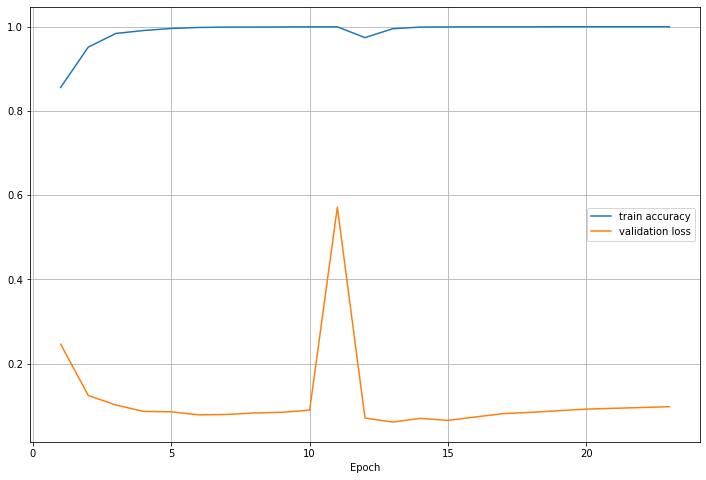

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,8))
plt.plot(xs, y_acc, label='train accuracy')
plt.plot(xs, y_vloss, label='validation loss')
plt.legend(), plt.grid()
plt.xlabel('Epoch')
plt.show()